# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

/usr/local/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/usr/local/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
#your turn
merged = pd.merge(df_transactions, df_offers)
merged.shape

(324, 9)

In [6]:
df_transactions['customer_name'].value_counts()

Sanders     9
Miller      7
Fisher      7
Sanchez     7
Peterson    6
           ..
Powell      1
Roberts     1
Ward        1
Ramirez     1
Green       1
Name: customer_name, Length: 100, dtype: int64

In [7]:
df_transactions.customer_name.value_counts()['Adams']

3

In [8]:
df_transactions.groupby(['customer_name']).size()

customer_name
Adams       3
Allen       2
Anderson    2
Bailey      2
Baker       4
           ..
Williams    3
Wilson      2
Wood        4
Wright      4
Young       6
Length: 100, dtype: int64

In [9]:
merged.isna().sum()

customer_name    0
offer_id         0
n                0
campaign         0
varietal         0
min_qty          0
discount         0
origin           0
past_peak        0
dtype: int64

In [10]:
pivoted = merged.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)

In [11]:
pivoted.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [12]:
# your turn
# from sklearn.cluster import KMeans
import sklearn.cluster
import numpy as np

# Sum of Squares list
ss = []
# n Cluster range
KRange = list(range(2, 11))
# 
assignments = {}
# X
X = pivoted.to_numpy()

for k in KRange:
    model = sklearn.cluster.KMeans(n_clusters=k)
    assigned_cluster = model.fit_predict(X)
    
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[assigned_cluster]) ** 2))
    assignments[str(k)] = assigned_cluster

In [13]:
# assignments: Dict
for key, value in assignments.items():
    print(key, assignments[key].shape)

2 (100,)
3 (100,)
4 (100,)
5 (100,)
6 (100,)
7 (100,)
8 (100,)
9 (100,)
10 (100,)


In [14]:
centers[assigned_cluster].shape

(100, 32)

In [15]:
assigned_cluster.shape

(100,)

In [16]:
centers.shape

(10, 32)

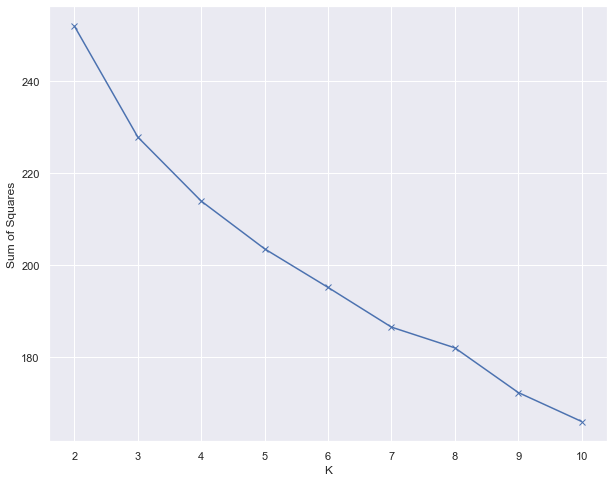

In [17]:
sns.set()
_ = plt.figure(figsize=(10, 8))
_ = plt.plot(KRange, ss, 'bx-')
_ = plt.xlabel("K")
_ = plt.ylabel("Sum of Squares")

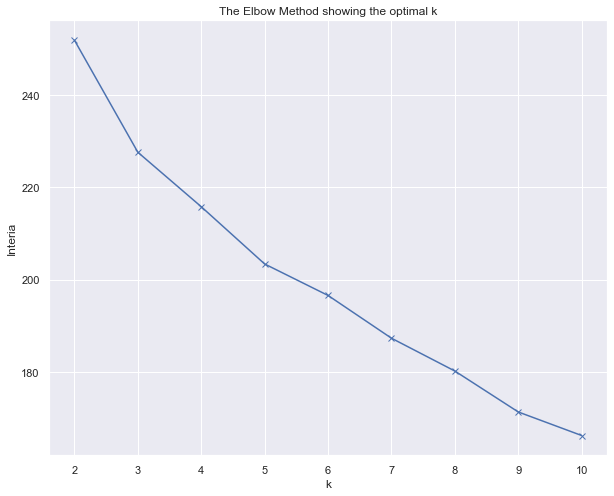

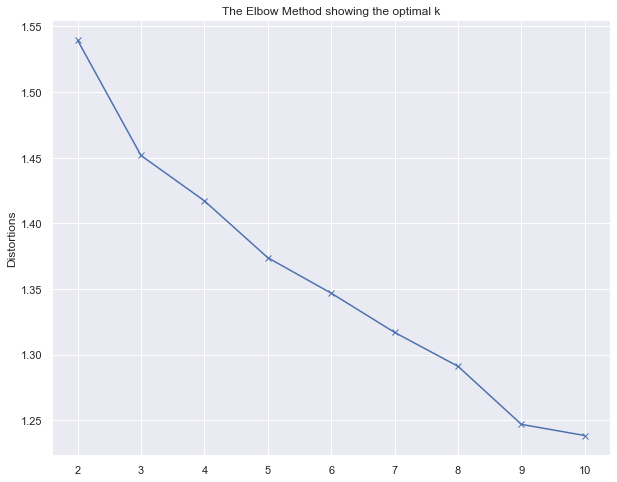

In [18]:
from scipy.spatial.distance import cdist

distortions = []
interia = []

for k in KRange:
    kmeanModel = sklearn.cluster.KMeans(n_clusters=k)
    kmeanModel.fit(X)
    interia.append(kmeanModel.inertia_)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow interia
sns.set()
_ = plt.figure(figsize=(10, 8))
_ = plt.plot(KRange, interia, 'bx-')
_ = plt.xlabel('k')
_ = plt.ylabel('Interia')
_ = plt.title('The Elbow Method showing the optimal k')
plt.show()
# Plot the elbow distortions
_ = plt.figure(figsize=(10, 8))
_ = plt.plot(KRange, distortions, 'bx-')
_ = plt.ylabel('Distortions')
_ = plt.title('The Elbow Method showing the optimal k')
plt.show()

In [19]:
distortions, ss, interia, kmeanModel.cluster_centers_.shape

([1.5394930205301898,
  1.4516912786748142,
  1.4171489471839736,
  1.3738226738604848,
  1.346821861184571,
  1.3169423772754922,
  1.2910968726542162,
  1.2468914146845862,
  1.2383952729062104],
 [251.95238095238096,
  227.84369429590018,
  213.93401805166513,
  203.5580065359477,
  195.17707219251338,
  186.54621553884712,
  182.04416833166835,
  172.3314393939394,
  166.03131313131314],
 [251.81333333333347,
  227.55739795918362,
  215.76890756302515,
  203.3734753550543,
  196.56316738816741,
  187.3075980392157,
  180.20251831501835,
  171.34358974358977,
  166.24623745819395],
 (10, 32))

In [20]:
[(i - j) for i, j in zip(interia, ss)]

[-0.13904761904748852,
 -0.2862963367165605,
 1.8348895113600179,
 -0.18453118089340137,
 1.3860951956540362,
 0.761382500368569,
 -1.841650016649993,
 -0.9878496503496308,
 0.21492432688080498]

3


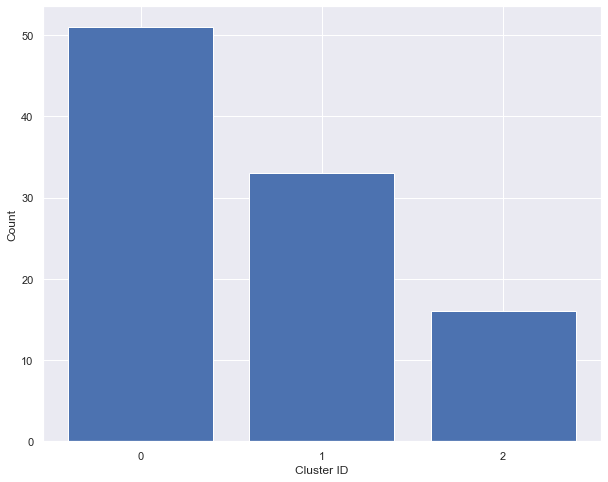

In [21]:
# What is the best K? Fill in the assignment below appropriately
best_K = 3
assignments_best_K = assignments[str(best_K)]
counts = np.bincount(assignments_best_K)
print(len(counts))

# Call bar() on plt, with parameters range(best_K), counts, and align = 'center'
_ = plt.figure(figsize=(10, 8))
_ = plt.bar(range(best_K), counts, align = 'center')

# Label the axes 
_ = plt.xlabel("Cluster ID")
_ = plt.ylabel("Count")
_ = plt.xticks(range(best_K))

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

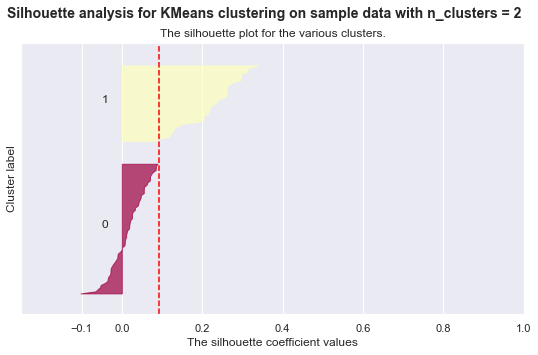

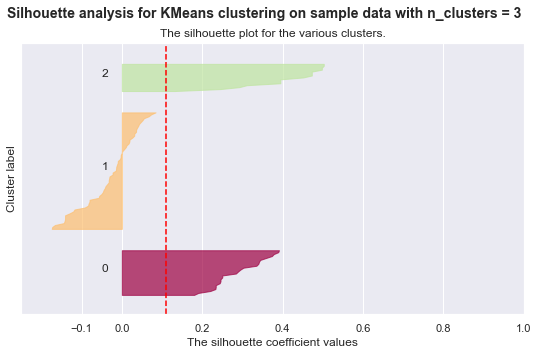

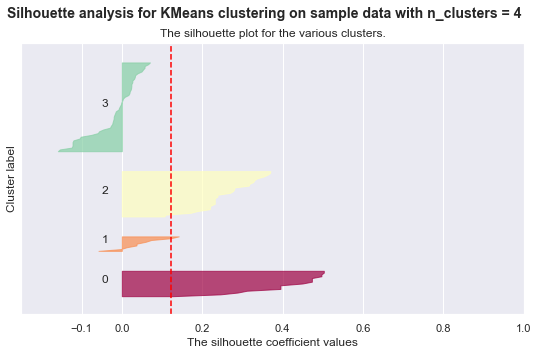

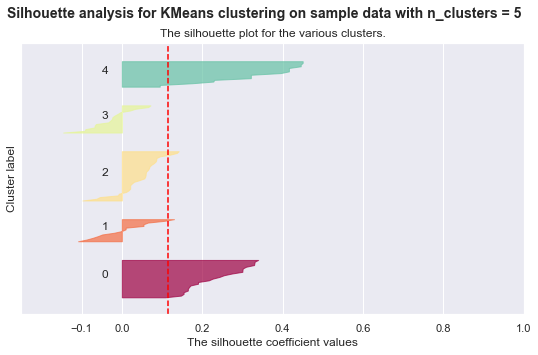

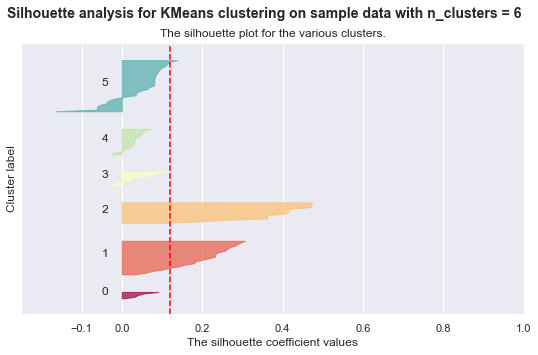

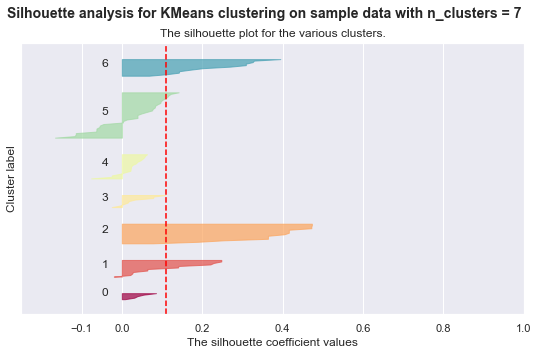

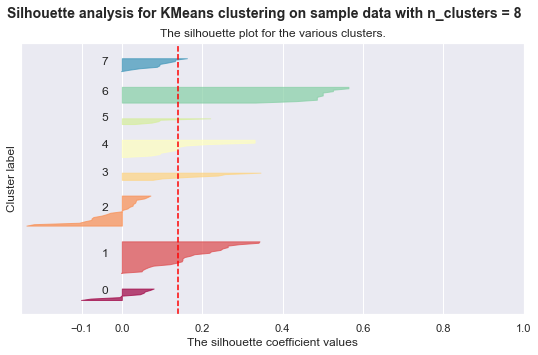

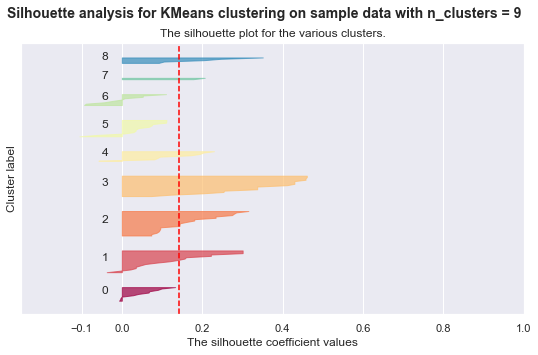

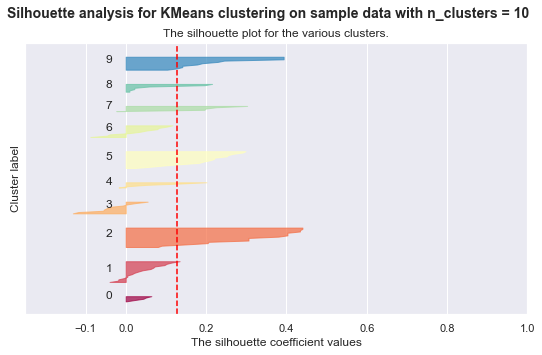

In [22]:
# This is an exercise in adapting someone else's code for our own use; a very common practice for data scientists and programmers alike
# OUR SOURCE: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import sklearn.metrics
import matplotlib.cm as cm


# Make an empty list called avg_silhouette_scores
avg_silhouette_scores = []

# Iterate through Krange with variable K as before
for K in KRange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # Call set_xlim on ax1 
    ax1.set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = sklearn.cluster.KMeans(n_clusters=K, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # Make a variable called silhouette_avg. Set the parameters to silhouette_score to X, and cluster_labels
    silhouette_avg  = sklearn.metrics.silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    # Call sklearn.metrics.silhouette_samples with the below parameters
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        # Make a variable called ith_cluster_silhouette_values
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        # Call sort() on this variable 
        ith_cluster_silhouette_values.sort()
    
        # Call shape[0] on ith_cluster_silhouette_values 
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        # This requires calling text() on ax1 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Setting title, xlabel and ylabel 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    # This requires axvline() 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % K),
                 fontsize=14, fontweight='bold')

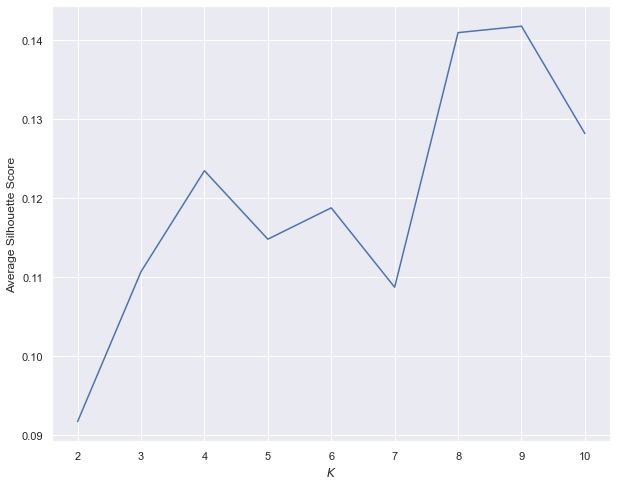

In [23]:
# Computing the avrage silhouette score for each K and plotting it 
# Call plot() with parameters KRange, avg_silhouette_scores
_ = plt.figure(figsize=(10, 8))
_ = plt.plot(KRange, avg_silhouette_scores)
_ = plt.xlabel("$K$")
_ = plt.ylabel("Average Silhouette Score")

In [24]:
# dont know what to conclude------

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.1107183912025193
For n_clusters = 4 The average silhouette_score is : 0.12349204708263416
For n_clusters = 5 The average silhouette_score is : 0.11482891379977885
For n_clusters = 6 The average silhouette_score is : 0.11879508142787866
For n_clusters = 7 The average silhouette_score is : 0.10874624428071616
For n_clusters = 8 The average silhouette_score is : 0.14097216560635834
For n_clusters = 9 The average silhouette_score is : 0.14178613108021745
For n_clusters = 10 The average silhouette_score is : 0.12819851045484193


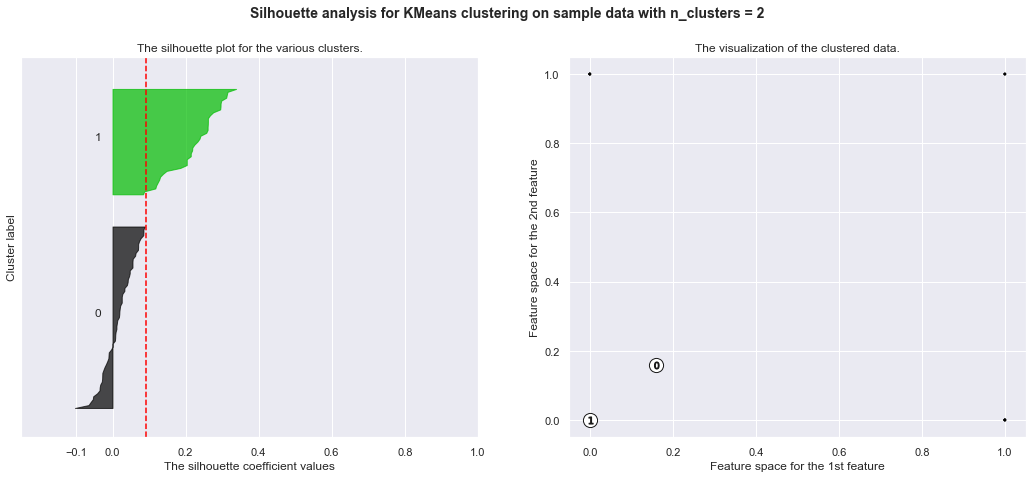

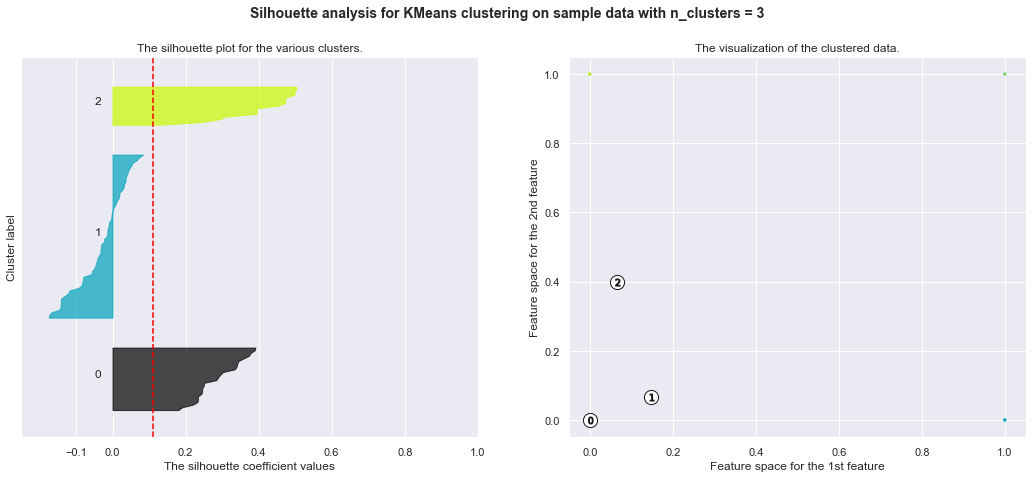

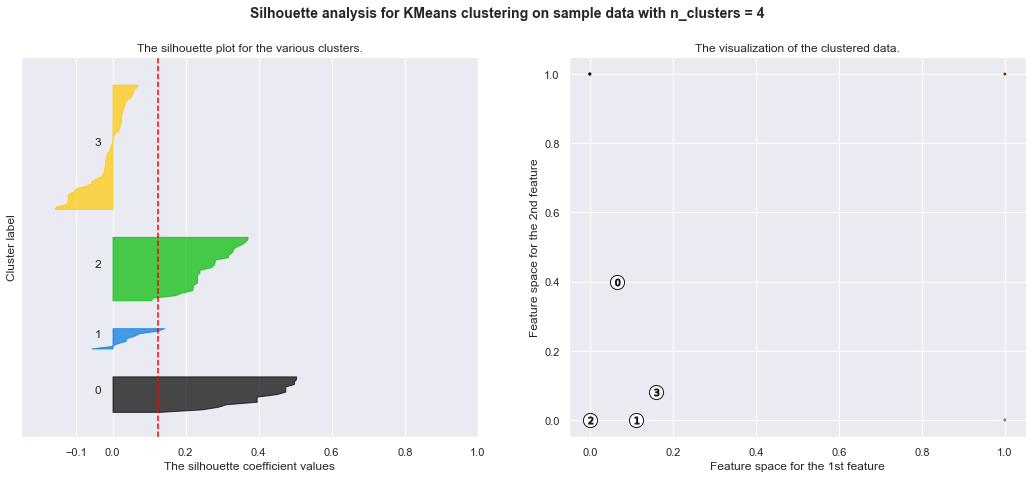

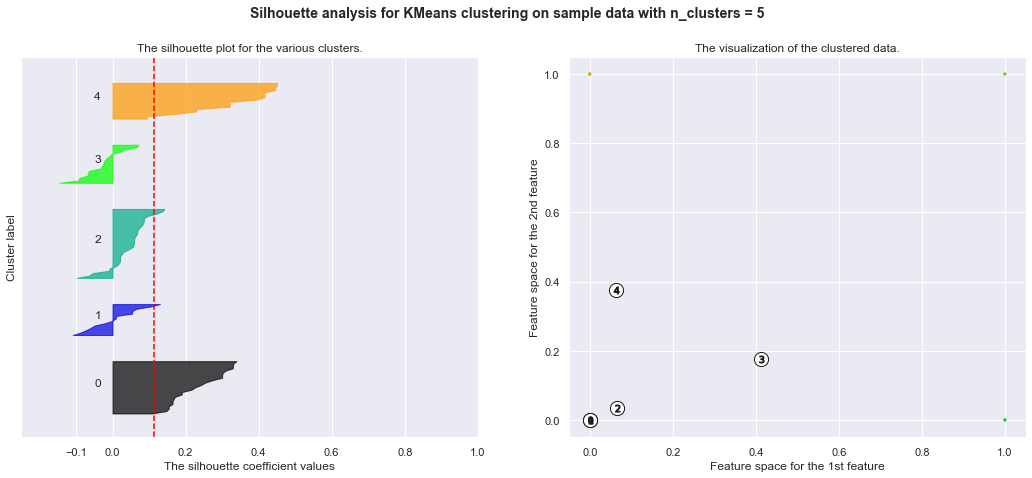

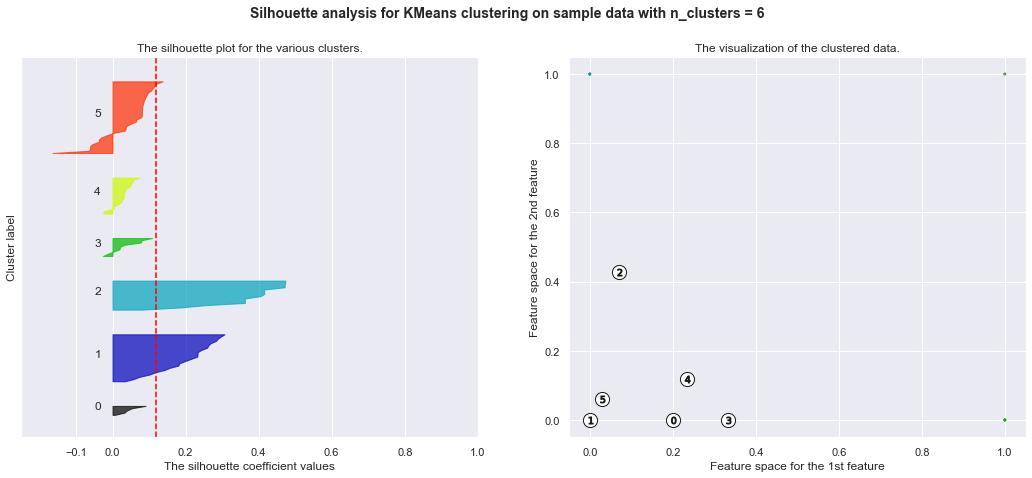

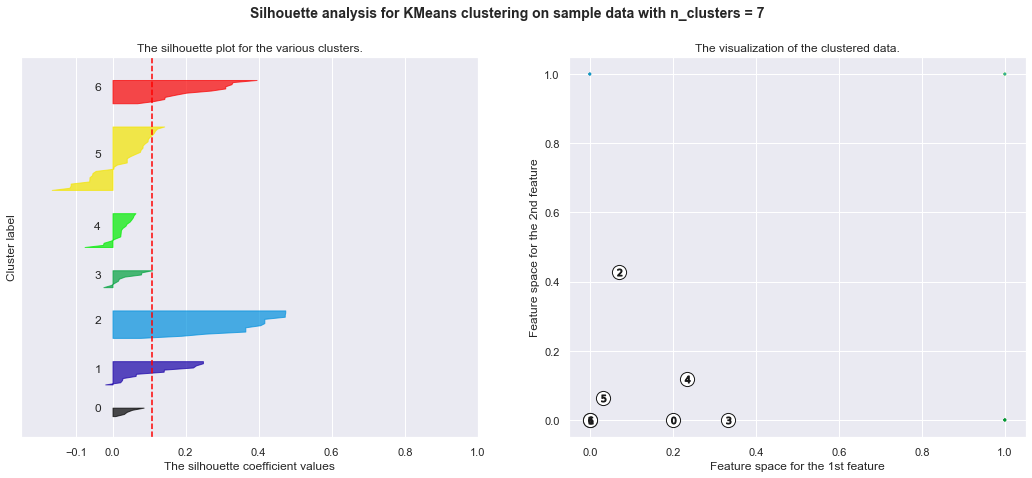

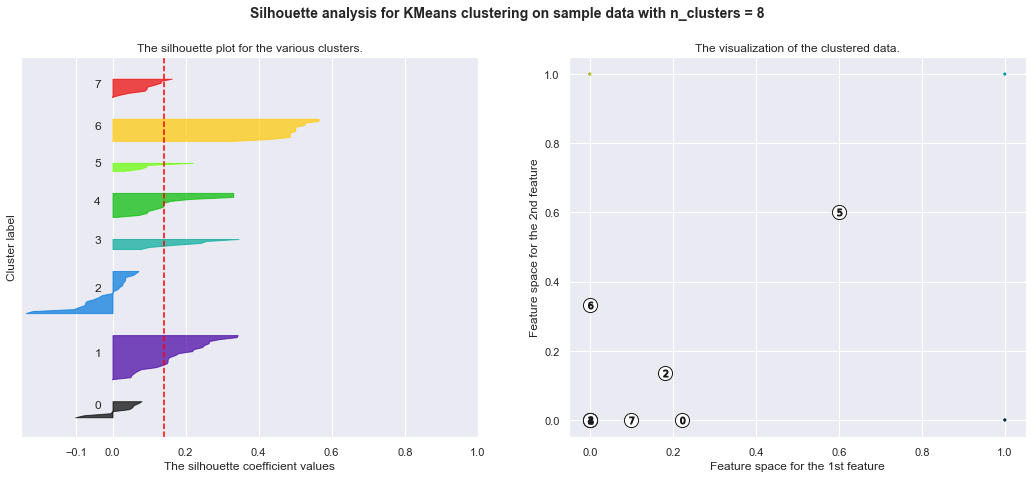

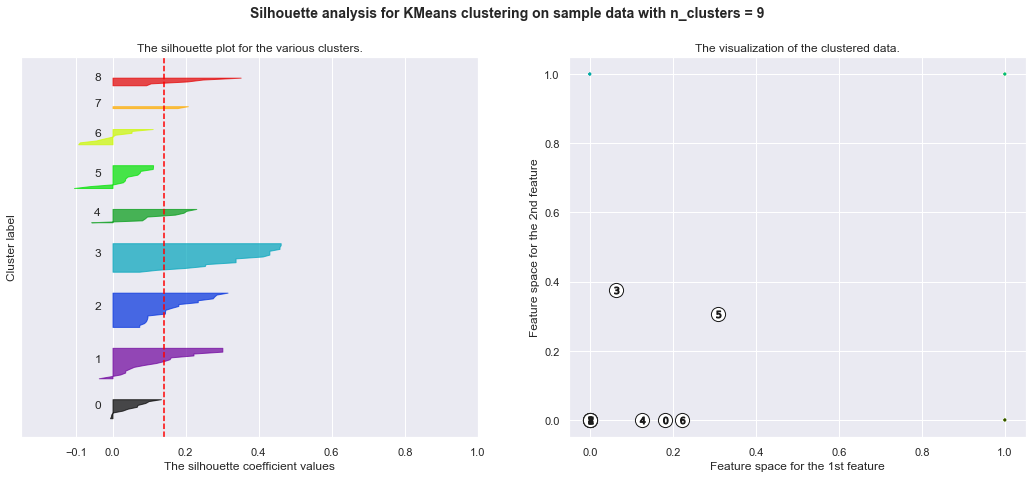

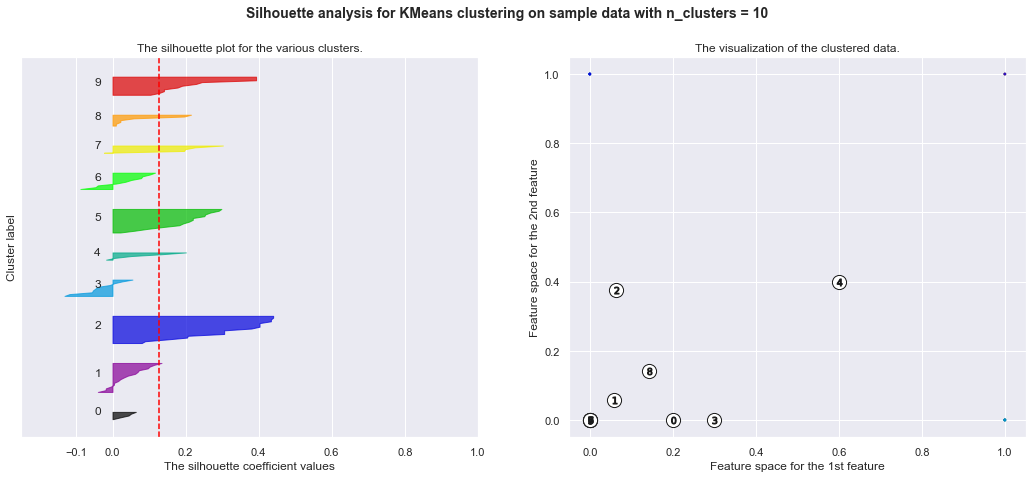

In [25]:
# Your turn.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

for n_clusters in KRange:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

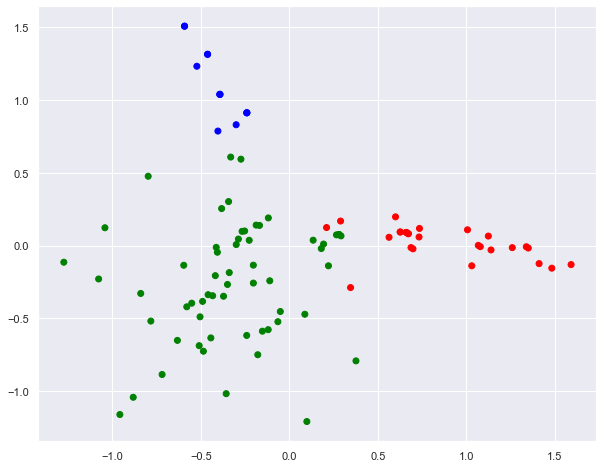

In [26]:
#your turn
from sklearn.cluster import KMeans

import sklearn.decomposition
import matplotlib.colors

# Make a variable called model. We want n_clusters = 3 as parameter to sklearn.cluster.KMeans 
model = KMeans(n_clusters=3)
# Call a fit_predict() on X 
cluster_assignments = model.fit_predict(X)

# Let's visualiaze with colors.ListedColormap
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

# We're going to do some PCA here. Call decomposition.PCA on sklearn, and pass n_components=2 as parameter
pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
_ = plt.figure(figsize=(10, 8))
_ = plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)

<Figure size 432x288 with 0 Axes>

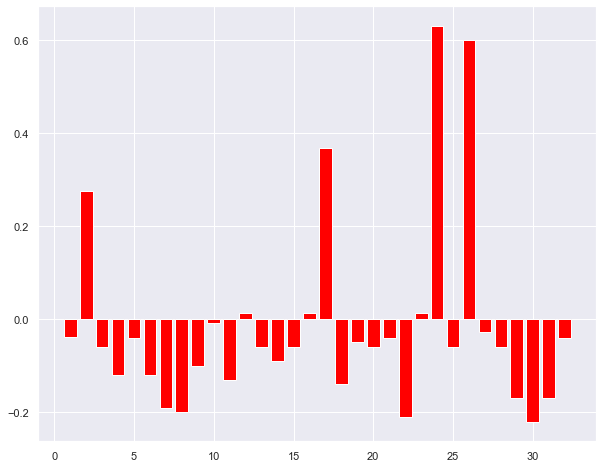

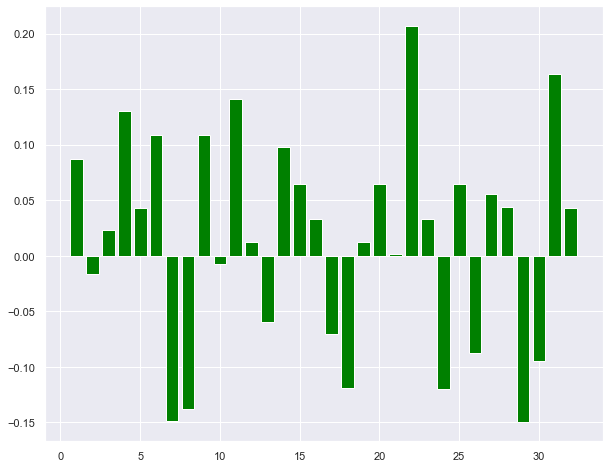

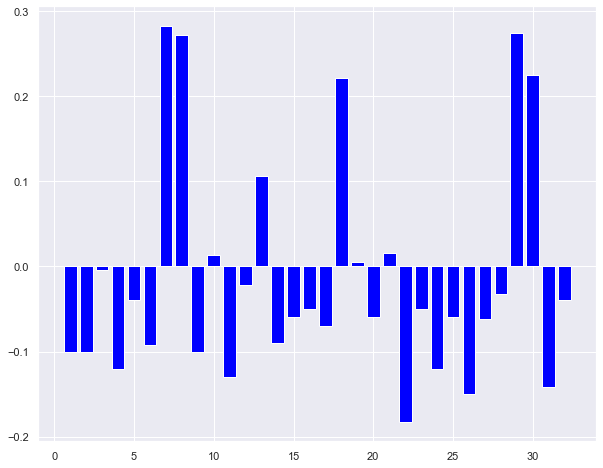

In [27]:
# Plot count of offer_id in each cluster.
# But, certain offers were used more than others in the original data.
# Let's compute the difference between how often they were used in each cluster vs globally.
model = sklearn.cluster.KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)

colors = ['red', 'green', 'blue']
offer_proportions = pivoted.sum(axis=0) / 100  # There are 100 customers
for i in range(3):
    plt.figure(i)
    cluster = pivoted[cluster_assignments == i]
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0]  # Number of customers in cluster
    lift = offer_proportions_cluster - offer_proportions
    plt.figure(figsize=(10, 8))
    plt.bar(range(1, 33), lift, color=colors[i])

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

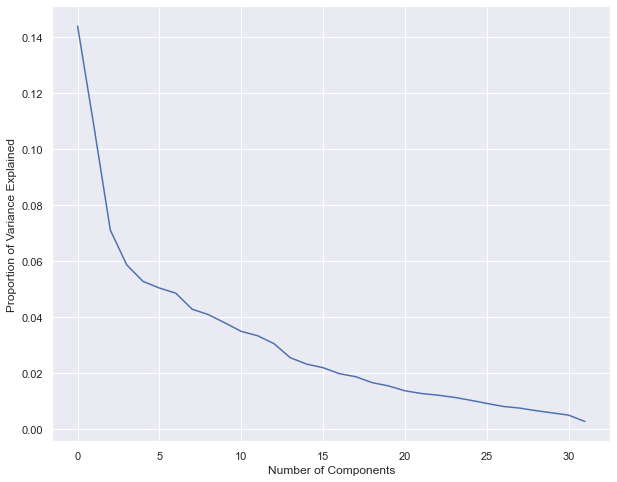

In [28]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition

# Do the rest on your own :)
# Call fit() on pca, with X passed to the method
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Let's finish this :)  Make a variable called variance
variance = pca.explained_variance_ratio_

# Plot() it 
_ = plt.figure(figsize=(10,8))
_ = plt.plot(range(len(variance)), variance)

# Label the axes
_ = plt.xlabel("Number of Components")
_ = plt.ylabel("Proportion of Variance Explained")


## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [29]:
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

In [30]:
# Your turn
# Affinity propagation
from sklearn.cluster import AffinityPropagation
import numpy as np

clustering = AffinityPropagation(damping=0.5,  max_iter=200, convergence_iter=15, copy=True, preference=None,
                                 affinity="euclidean", verbose=False, random_state=0)
clustering.fit(X)

print(clustering.get_params())
print('\n')
#  The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
print('Silhouette Score: ', metrics.silhouette_score(X, clustering.labels_, metric='euclidean'))
# The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
print('Calinski Harabasz Score: ', metrics.calinski_harabasz_score(X, clustering.labels_))
# Zero is the lowest possible score. Values closer to zero indicate a better partition.
print('Davies Bouldin Score: ', davies_bouldin_score(X, clustering.labels_))

{'affinity': 'euclidean', 'convergence_iter': 15, 'copy': True, 'damping': 0.5, 'max_iter': 200, 'preference': None, 'random_state': 0, 'verbose': False}


Silhouette Score:  0.12346523604478911
Calinski Harabasz Score:  6.110277512796729
Davies Bouldin Score:  1.7097205862797205


In [31]:
# Your turn
# Affinity propagation
from sklearn.cluster import AffinityPropagation
import numpy as np

clusteringFP = AffinityPropagation(damping=0.5,  max_iter=200, convergence_iter=50, copy=True, preference=None,
                                 affinity="euclidean", verbose=False, random_state=0)

clusteringFP.fit_predict(X)

print(clusteringFP.get_params())
print('\n')
#  The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
print('Silhouette Score: ', metrics.silhouette_score(X, clusteringFP.labels_, metric='euclidean'))
# The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
print('Calinski Harabasz Score: ', metrics.calinski_harabasz_score(X, clusteringFP.labels_))
# Zero is the lowest possible score. Values closer to zero indicate a better partition.
print('Davies Bouldin Score: ', davies_bouldin_score(X, clusteringFP.labels_))

{'affinity': 'euclidean', 'convergence_iter': 50, 'copy': True, 'damping': 0.5, 'max_iter': 200, 'preference': None, 'random_state': 0, 'verbose': False}


Silhouette Score:  0.12644347246665763
Calinski Harabasz Score:  6.270004062760592
Davies Bouldin Score:  1.6888471895185597


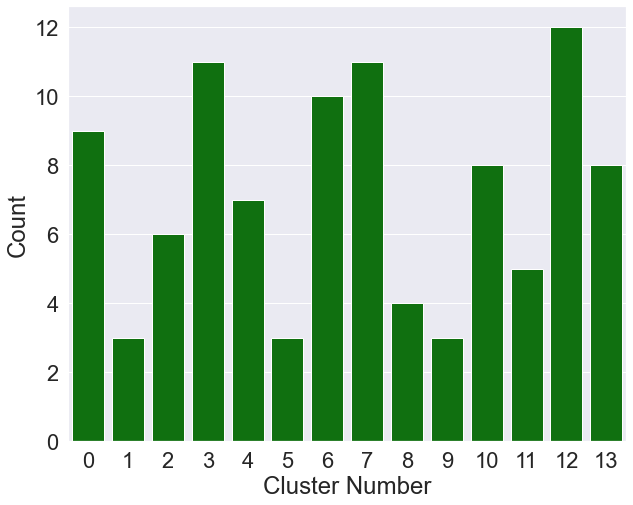

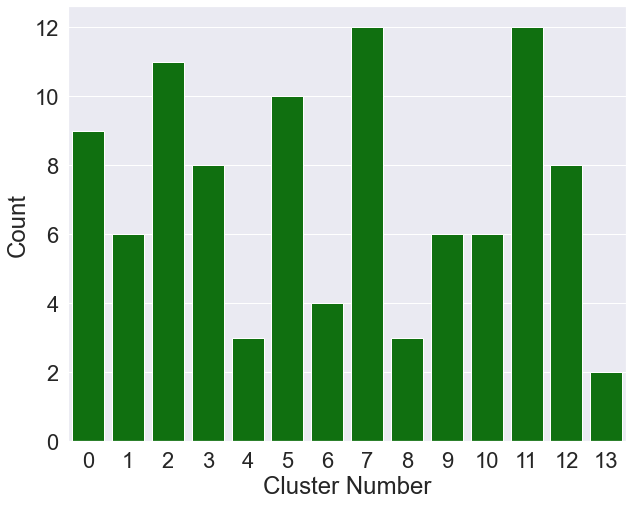

In [32]:
df = pd.DataFrame(clustering.labels_, columns=['Cluster_Number'])

ax = sns.set(font_scale=2, rc={'figure.figsize':(10,8)})
ax = sns.countplot(x="Cluster_Number", data=df, color='green')
ax.set(xlabel="Cluster Number", ylabel = "Count")
plt.show()

df = pd.DataFrame(clusteringFP.labels_, columns=['Cluster_Number'])

ax = sns.set(font_scale=2, rc={'figure.figsize':(10,8)})
ax = sns.countplot(x="Cluster_Number", data=df, color='green')
ax.set(xlabel="Cluster Number", ylabel = "Count")
plt.show()

In [33]:
clustering.cluster_centers_[0:1], clusteringFP.cluster_centers_[0:1]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 0, 0]]))

In [34]:
print('Labels of each point shape: ', clustering.cluster_centers_.shape, clusteringFP.cluster_centers_.shape)
print('Cluster centers (if affinity != precomputed) shape: ',clustering.cluster_centers_.shape, clusteringFP.cluster_centers_.shape)
print('Indices of cluster centers shape: ', clustering.cluster_centers_indices_.shape, clusteringFP.cluster_centers_indices_.shape)
print('Stores the affinity matrix used in fit shape: ', clustering.affinity_matrix_.shape, clusteringFP.affinity_matrix_.shape, )
print('Number of iterations taken to converge: ', clustering.n_iter_, clusteringFP.n_iter_)

Labels of each point shape:  (14, 32) (14, 32)
Cluster centers (if affinity != precomputed) shape:  (14, 32) (14, 32)
Indices of cluster centers shape:  (14,) (14,)
Stores the affinity matrix used in fit shape:  (100, 100) (100, 100)
Number of iterations taken to converge:  47 112


In [35]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=3, random_state=0).fit(X)

print(clustering.labels_.shape)
print(clustering.affinity_matrix_.shape)
print('\n')
print(clustering)
print('\n')
#  The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
print('Silhouette Score: ', metrics.silhouette_score(X, clustering.labels_, metric='euclidean'))
# The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
print('Calinski Harabasz Score: ', metrics.calinski_harabasz_score(X, clustering.labels_))
# Zero is the lowest possible score. Values closer to zero indicate a better partition.
print('Davies Bouldin Score: ', davies_bouldin_score(X, clustering.labels_))

(100,)
(100, 100)


SpectralClustering(n_clusters=3, random_state=0)


Silhouette Score:  0.10611539040197304
Calinski Harabasz Score:  11.205372023597176
Davies Bouldin Score:  2.239586052480093


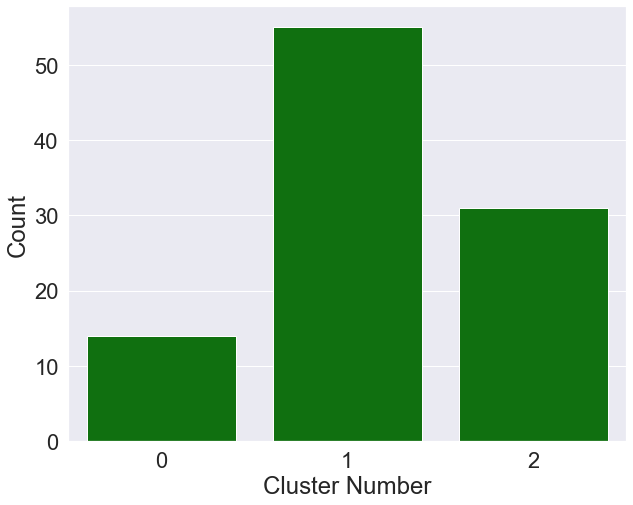

In [36]:
df = pd.DataFrame(clustering.labels_, columns=['Cluster_Number'])

ax = sns.set(font_scale=2, rc={'figure.figsize':(10,8)})
ax = sns.countplot(x="Cluster_Number", data=df, color='green')
ax.set(xlabel="Cluster Number", ylabel = "Count")
plt.show()

In [37]:
# AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3).fit(X)

print(clustering.labels_.shape)
print(clustering.n_leaves_)
print(clustering.n_connected_components_)
print(clustering.children_.shape)
print('\n')
print(clustering)
print('\n')
#  The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
print('Silhouette Score: ', metrics.silhouette_score(X, clustering.labels_, metric='euclidean'))
# The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
print('Calinski Harabasz Score: ', metrics.calinski_harabasz_score(X, clustering.labels_))
# Zero is the lowest possible score. Values closer to zero indicate a better partition.
print('Davies Bouldin Score: ', davies_bouldin_score(X, clustering.labels_))

(100,)
100
1
(99, 2)


AgglomerativeClustering(n_clusters=3)


Silhouette Score:  0.11625878863607858
Calinski Harabasz Score:  11.44899869194348
Davies Bouldin Score:  2.3267350419583397


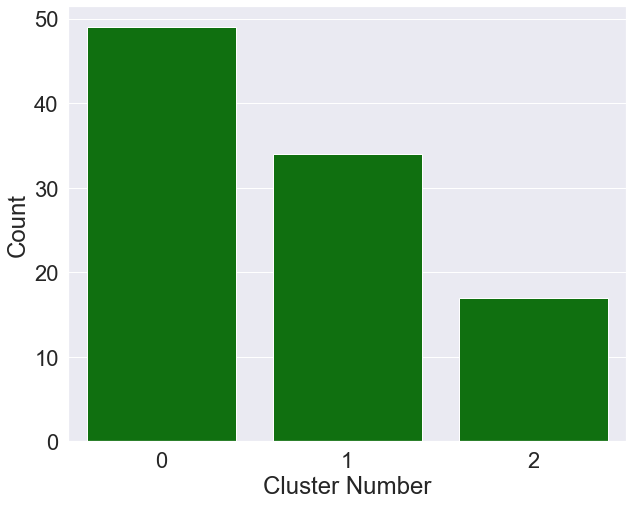

In [38]:
df = pd.DataFrame(clustering.labels_, columns=['Cluster_Number'])

ax = sns.set(font_scale=2, rc={'figure.figsize':(10,8)})
ax = sns.countplot(x="Cluster_Number", data=df, color='green')
ax.set(xlabel="Cluster Number", ylabel = "Count")
plt.show()

Automatically created module for IPython interactive environment
Estimated number of clusters: 1
Estimated number of noise points: 3
(100,)
(80,)
(80, 32)
{'algorithm': 'auto', 'eps': 2, 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'min_samples': 10, 'n_jobs': None, 'p': None}


DBSCAN(eps=2, min_samples=10)
Silhouette Score:  0.2348896595208253
Calinski Harabasz Score:  4.4966749113904685
Davies Bouldin Score:  1.5014761737135693


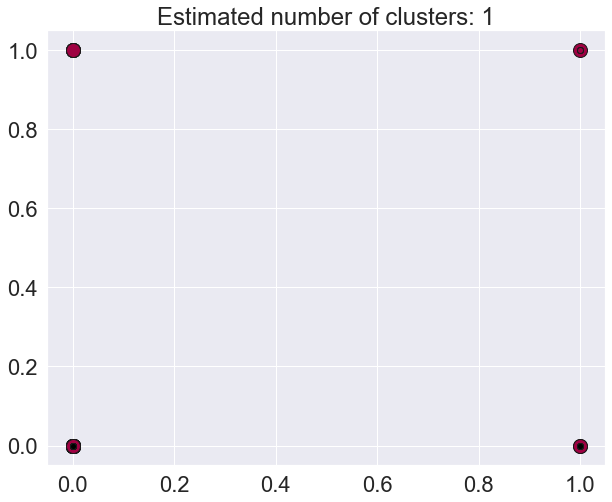

In [39]:
print(__doc__)
# DBSCAN
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=2, min_samples=10, metric="euclidean")
clustering.fit_predict(X)

core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

print(clustering.labels_.shape)
print(clustering.core_sample_indices_.shape)
print(clustering.components_.shape)
print(clustering.get_params())
print('\n')
print(clustering)

#  The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
print('Silhouette Score: ', metrics.silhouette_score(X, clustering.labels_, metric='euclidean'))
# The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
print('Calinski Harabasz Score: ', metrics.calinski_harabasz_score(X, clustering.labels_))
# Zero is the lowest possible score. Values closer to zero indicate a better partition.
print('Davies Bouldin Score: ', davies_bouldin_score(X, clustering.labels_))

#############################################################
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


## Clustering performance evaluation

### Rand index
Given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the (adjusted or unadjusted) Rand index is a function that measures the similarity of the two assignments, ignoring permutations:

In [40]:
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 1, 1]

# metrics.rand_score(labels_true, labels_pred)
metrics.adjusted_rand_score(labels_true, labels_pred)

0.32432432432432434

Poorly agreeing labels for the adjusted Rand index the score will be negative or close to zero. 

In [41]:
labels_true = [0, 0, 0, 0, 0, 0, 1, 1]
labels_pred = [0, 1, 2, 3, 4, 5, 5, 6]
metrics.adjusted_rand_score(labels_true, labels_pred)

-0.07207207207207207

- **Interpretability:** The unadjusted Rand index is proportional to the number of sample pairs whose labels are the same in both labels_pred and labels_true, or are different in both.
- **Random (uniform) label assignments have an adjusted Rand index score close to 0.0** for any value of n_clusters and n_samples (which is not the case for the unadjusted Rand index or the V-measure for instance).
- **Bounded range:** Lower values indicate different labelings, similar clusterings have a high (adjusted or unadjusted) Rand index, 1.0 is the perfect match score. The score range is [0, 1] for the unadjusted Rand index and [-1, 1] for the adjusted Rand index.
- **No assumption is made on the cluster structure:** The (adjusted or unadjusted) Rand index can be used to compare all kinds of clustering algorithms, and can be used to compare clustering algorithms such as k-means which assumes isotropic blob shapes with results of spectral clustering algorithms which can find cluster with “folded” shapes.

 - Contrary to inertia, the **(adjusted or unadjusted) Rand index requires knowledge of the ground truth classes** which is almost never available in practice or requires manual assignment by human annotators (as in the supervised learning setting).
 - However (adjusted or unadjusted) Rand index can also be useful in a purely unsupervised setting as a building block for a Consensus Index that can be used for clustering model selection (TODO).
 - The **unadjusted Rand index is often close to 1.0** even if the clusterings themselves differ significantly. This can be understood when interpreting the Rand index as the accuracy of element pair labeling resulting from the clusterings: In practice there often is a majority of element pairs that are assigned the different pair label under both the predicted and the ground truth clustering resulting in a high proportion of pair labels that agree, which leads subsequently to a high score.

### Mutual Information based scores
Given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the **Mutual Information** is a function that measures the **agreement** of the two assignments, ignoring permutations. Two different normalized versions of this measure are available, **Normalized Mutual Information (NMI)** and **Adjusted Mutual Information (AMI)**. NMI is often used in the literature, while AMI was proposed more recently and is **normalized against chance.**

In [42]:
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
metrics.adjusted_mutual_info_score(labels_true, labels_pred)

0.29879245817089006

One can permute 0 and 1 in the predicted labels, rename 2 to 3 and get the same score:

In [43]:
labels_pred = [1, 1, 0, 0, 3, 3]
metrics.adjusted_mutual_info_score(labels_true, labels_pred)

0.29879245817089006

All, mutual_info_score, adjusted_mutual_info_score and normalized_mutual_info_score are symmetric: swapping the argument does not change the score. Thus they can be used as a **consensus measure.**

In [44]:
metrics.adjusted_mutual_info_score(labels_pred, labels_true) 

0.29879245817089006

Perfect labeling is scored 1.0:

In [45]:
labels_pred = labels_true[:]
print(metrics.adjusted_mutual_info_score(labels_true, labels_pred))
print(metrics.normalized_mutual_info_score(labels_true, labels_pred))

1.0
1.0


This is not true for mutual_info_score, which is therefore harder to judge:

In [46]:
metrics.mutual_info_score(labels_true, labels_pred) 

0.6931471805599452

Bad (e.g. independent labelings) have non-positive scores:

In [47]:
labels_true = [0, 1, 2, 0, 3, 4, 5, 1]
labels_pred = [1, 1, 0, 0, 2, 2, 2, 2]
metrics.adjusted_mutual_info_score(labels_true, labels_pred)  

-0.166666666666667

In [48]:
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [1, 1, 1, 0, 0, 0]

print(metrics.adjusted_mutual_info_score(labels_true, labels_pred))
print(metrics.normalized_mutual_info_score(labels_true, labels_pred))

1.0
1.0


- **Random (uniform) label assignments have a AMI score close to 0.0** for any value of n_clusters and n_samples (which is not the case for raw Mutual Information or the V-measure for instance).
- **Upper bound of 1:** Values close to zero indicate two label assignments that are largely independent, while values close to one indicate significant agreement. Further, an AMI of exactly 1 indicates that the two label assignments are equal (with or without permutation).

 - Contrary to inertia, **MI-based measures require the knowledge of the ground truth classes** while almost never available in practice or requires manual assignment by human annotators (as in the supervised learning setting).
 - However MI-based measures can also be useful in purely unsupervised setting as a building block for a Consensus Index that can be used for clustering model selection.
 - NMI and MI are not adjusted against chance.

## Homogeneity, completeness and V-measure

Given the knowledge of the ground truth class assignments of the samples, it is possible to define some intuitive metric using conditional entropy analysis.

In particular Rosenberg and Hirschberg (2007) define the following two desirable objectives for any cluster assignment:

- **homogeneity:** each cluster contains only members of a single class.
- **completeness:** all members of a given class are assigned to the same cluster.

We can turn those concept as scores homogeneity_score and completeness_score. Both are bounded below by 0.0 and above by 1.0 (higher is better).

In [49]:
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]

print(metrics.homogeneity_score(labels_true, labels_pred))
print(metrics.completeness_score(labels_true, labels_pred))

0.6666666666666669
0.420619835714305


#### Their harmonic mean called **V-measure** is computed by v_measure_score:

In [50]:
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]

metrics.v_measure_score(labels_true, labels_pred)

0.5158037429793889

##### **beta** defaults to a value of 1.0, but for using a value less than 1 for beta:

In [51]:
metrics.v_measure_score(labels_true, labels_pred, beta=0.6)

0.5467344787062375

##### more weight will be attributed to homogeneity, and using a value greater than 1:

In [52]:
metrics.v_measure_score(labels_true, labels_pred, beta=1.8)

0.48447946234141737

In [53]:
metrics.homogeneity_completeness_v_measure(labels_true, labels_pred)

(0.6666666666666669, 0.420619835714305, 0.5158037429793889)

In [54]:
labels_pred = [0, 0, 0, 1, 2, 2]
metrics.homogeneity_completeness_v_measure(labels_true, labels_pred)

(1.0, 0.6853314789615865, 0.8132898335036762)

##### These metrics require the knowledge of the ground truth classes while almost never available in practice or requires manual assignment by human annotators (as in the supervised learning setting).

- **Bounded scores:** 0.0 is as bad as it can be, 1.0 is a perfect score.
- Intuitive interpretation: clustering with bad V-measure can be **qualitatively analyzed in terms of homogeneity and completeness** to better feel what ‘kind’ of mistakes is done by the assignment.
- **No assumption is made on the cluster structure:** can be used to compare clustering algorithms such as k-means which assumes isotropic blob shapes with results of spectral clustering algorithms which can find cluster with “folded” shapes.

 - The previously introduced metrics are **not normalized with regards to random labeling:** this means that depending on the number of samples, clusters and ground truth classes, a completely random labeling will not always yield the same values for homogeneity, completeness and hence v-measure. In particular **random labeling won’t yield zero scores especially when the number of clusters is large.**
 - This problem can safely be ignored when the number of samples is more than a thousand and the number of clusters is less than 10. **For smaller sample sizes or larger number of clusters it is safer to use an adjusted index such as the Adjusted Rand Index (ARI).**

### Fowlkes-Mallows scores

The Fowlkes-Mallows index (sklearn.metrics.fowlkes_mallows_score) can be used when the ground truth class assignments of the samples is known. The Fowlkes-Mallows score FMI is defined as the geometric mean of the pairwise precision and recall:

**FMI = TP / Sqrt((TP + FP)(TP + FN))**
 
Where TP is the number of True Positive (i.e. the number of pair of points that belong to the same clusters in both the true labels and the predicted labels), FP is the number of False Positive (i.e. the number of pair of points that belong to the same clusters in the true labels and not in the predicted labels) and FN is the number of False Negative (i.e the number of pair of points that belongs in the same clusters in the predicted labels and not in the true labels).

The score ranges from 0 to 1. A high value indicates a good similarity between two clusters.

In [55]:
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
metrics.fowlkes_mallows_score(labels_true, labels_pred)

0.4714045207910317

In [56]:
labels_pred = [1, 1, 0, 0, 3, 3]
metrics.fowlkes_mallows_score(labels_true, labels_pred)

0.4714045207910317

In [57]:
labels_true = [0, 1, 2, 0, 3, 4, 5, 1]
labels_pred = [1, 1, 0, 0, 2, 2, 2, 2]
metrics.fowlkes_mallows_score(labels_true, labels_pred)

0.0

- **Random (uniform) label assignments have a FMI score close to 0.0** for any value of n_clusters and n_samples (which is not the case for raw Mutual Information or the V-measure for instance).
- **Upper-bounded at 1:** Values close to zero indicate two label assignments that are largely independent, while values close to one indicate significant agreement. Further, values of exactly 0 indicate purely independent label assignments and a FMI of exactly 1 indicates that the two label assignments are equal (with or without permutation).
- **No assumption is made on the cluster structure:** can be used to compare clustering algorithms such as k-means which assumes isotropic blob shapes with results of spectral clustering algorithms which can find cluster with “folded” shapes.

 - Contrary to inertia, **FMI-based measures require the knowledge of the ground truth classes** while almost never available in practice or requires manual assignment by human annotators (as in the supervised learning setting).

### Silhouette Coefficient

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

**s = b-a / max(a,b)**

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

In [58]:
metrics.silhouette_score(X, clustering.labels_, metric='euclidean')

0.2348896595208253

- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
 - The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

### Calinski-Harabasz Index
- If the ground truth labels are not known, the Calinski-Harabasz index (sklearn.metrics.calinski_harabasz_score) - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.
- The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared):

In [59]:
metrics.calinski_harabasz_score(X, clustering.labels_)

4.4966749113904685

- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
- The score is fast to compute.
 - The Calinski-Harabasz index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

### Davies-Bouldin Index
- if the ground truth labels are not known, the Davies-Bouldin index (sklearn.metrics.davies_bouldin_score) can be used to evaluate the model, where a lower Davies-Bouldin index relates to a model with better separation between the clusters.
- This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.
- Zero is the lowest possible score. Values closer to zero indicate a better partition.

In [60]:
davies_bouldin_score(X, clustering.labels_)

1.5014761737135693

- The computation of Davies-Bouldin is simpler than that of Silhouette scores.
- The index is computed only quantities and features inherent to the dataset.
 - The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained from DBSCAN.
 - The usage of centroid distance limits the distance metric to Euclidean space.

### Contingency Matrix
Contingency matrix (sklearn.metrics.cluster.contingency_matrix) reports the intersection cardinality for every true/predicted cluster pair. The contingency matrix provides sufficient statistics for all clustering metrics where the samples are independent and identically distributed and one doesn’t need to account for some instances not being clustered.

In [61]:
from sklearn.metrics.cluster import contingency_matrix

x = ["a", "a", "a", "b", "b", "b"]
y = [0, 0, 1, 1, 2, 2]

contingency_matrix(x, y)

array([[2, 1, 0],
       [0, 1, 2]])

The first row of output array indicates that there are three samples whose true cluster is “a”. Of them, two are in predicted cluster 0, one is in 1, and none is in 2. And the second row indicates that there are three samples whose true cluster is “b”. Of them, none is in predicted cluster 0, one is in 1 and two are in 2.

A confusion matrix for classification is a square contingency matrix where the order of rows and columns correspond to a list of classes.

- Allows to examine the spread of each true cluster across predicted clusters and vice versa.
- The contingency table calculated is typically utilized in the calculation of a similarity statistic (like the others listed in this document) between the two clusterings.
 - Contingency matrix is easy to interpret for a small number of clusters, but becomes very hard to interpret for a large number of clusters.
 - It doesn’t give a single metric to use as an objective for clustering optimisation.

In [62]:
from sklearn.metrics import confusion_matrix

confusion_matrix([0, 0, 1, 1], [0, 0, 1, 1])

array([[2, 0],
       [0, 2]])

In [63]:
confusion_matrix([0, 0, 1, 1], [1, 1, 0, 0])

array([[0, 2],
       [2, 0]])

In [64]:
confusion_matrix([0, 0, 1, 1], [0, 0, 1, 2])

array([[2, 0, 0],
       [0, 1, 1],
       [0, 0, 0]])

In [65]:
confusion_matrix([0, 0, 0, 0], [0, 1, 2, 3])

array([[1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])